### importación de las librerias a usar

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import ast

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# 1: Análisis exploratorio de datos (EDA)

### Lectura del dataset con Pandas

In [2]:

ruta_archivo = '../data/new_items_dataset.csv'
df = pd.read_csv(ruta_archivo)

C:\Users\linam\AppData\Local\Temp\ipykernel_24072\336152042.py:2: DtypeWarning: Columns (10,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo)


In [3]:
len(df)

100000

#### Histograma para verificar que variable se ajusta más a ser la variable objetivo del modelo

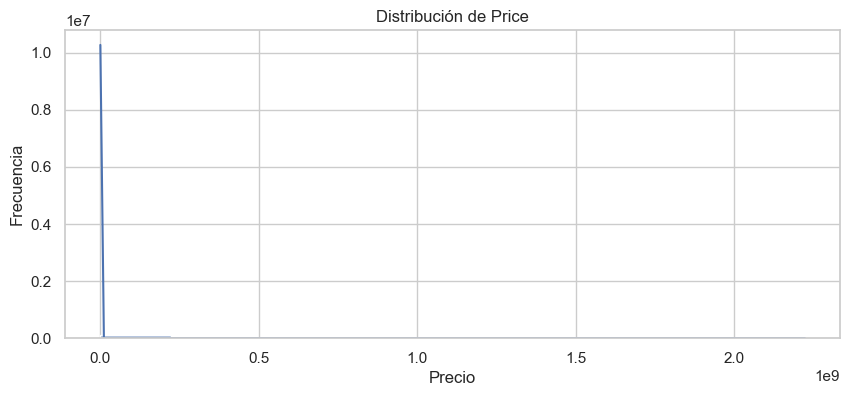

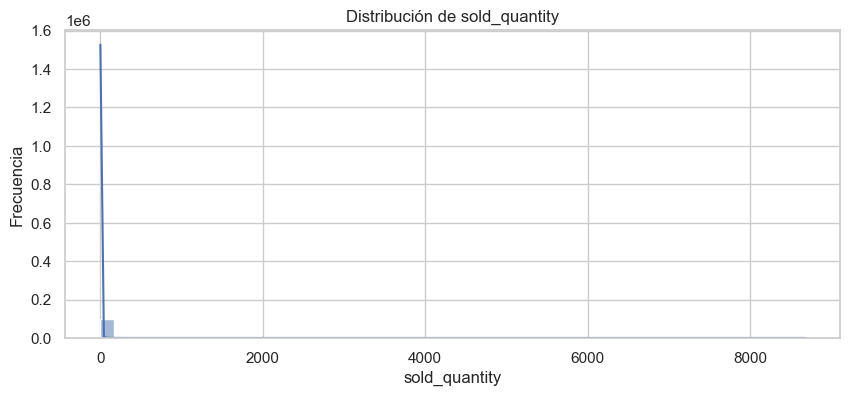

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajustes generales de estilo
sns.set(style="whitegrid")

# Histograma de 'price'
plt.figure(figsize=(10, 4))
sns.histplot(df['price'], bins=10, kde=True)
plt.title('Distribución de Price')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

# Histograma de 'sold_quantity'
plt.figure(figsize=(10, 4))
sns.histplot(df['sold_quantity'], bins=50, kde=True)
plt.title('Distribución de sold_quantity')
plt.xlabel('sold_quantity')
plt.ylabel('Frecuencia')
plt.show()

#### Como las variables están altamente sesgadas hacia el 0 se procede a filtrar algunos outliers para el precio y el país (dado que el precio no está claro si está dado en alguna moneda particular), por esto se tomarán los precios menores a 10000 y las filas de las que el país del vendedor sea Argentina que es la mayoría del df

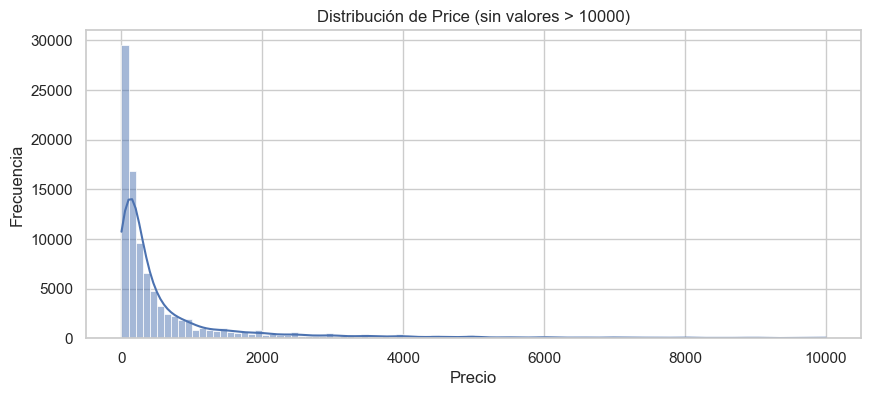

In [5]:

df_argentina = df[df['seller_country'] == 'Argentina']
df_filtrado = df_argentina[df_argentina['price'] <= 10_000]

# Volver a graficar el histograma de price sin outliers
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.histplot(df_filtrado['price'], bins=100, kde=True)
plt.title('Distribución de Price (sin valores > 10000)')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()


#### Se verifica una distribución mejor balanceada para la variable precio.

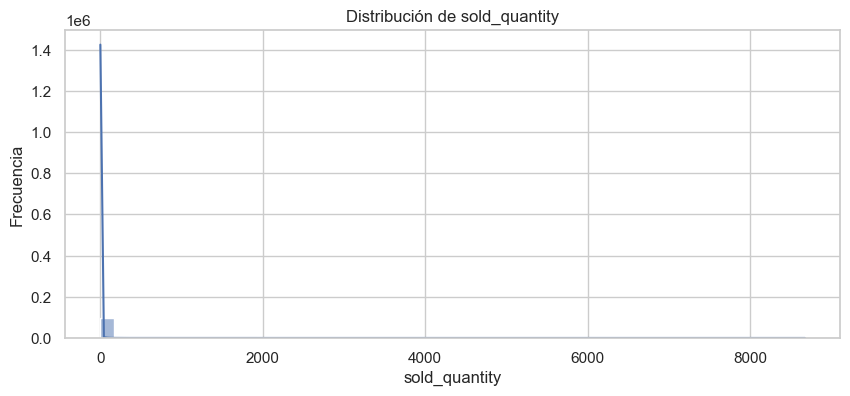

In [6]:
plt.figure(figsize=(10, 4))
sns.histplot(df_filtrado['sold_quantity'], bins=50, kde=True)
plt.title('Distribución de sold_quantity')
plt.xlabel('sold_quantity')
plt.ylabel('Frecuencia')
plt.show()

##### Con el histograma de arriba se verifica que aun filtrando como se dijo más arriba la columna sold_quality no es una buena variable objetivo a menos que se discretice. 

In [7]:
# Estadísticas descriptivas
print(df_filtrado['sold_quantity'].describe())

# Valores únicos ordenados
print("Valores únicos más frecuentes:")
print(df_filtrado['sold_quantity'].value_counts().sort_index().head(20)) 

# Cuántos ceros hay
ceros = (df_filtrado['sold_quantity'] == 0).sum()
print(f'Cantidad de productos con 0 unidades vendidas: {ceros}')
print(f'Porcentaje de ceros: {ceros / len(df_filtrado) * 100:.2f}%')


count    96041.000000
mean         2.485595
std         43.549101
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       8676.000000
Name: sold_quantity, dtype: float64
Valores únicos más frecuentes:
sold_quantity
0.0     79348
1.0      6460
2.0      2468
3.0      1331
4.0       941
5.0       663
6.0       508
7.0       389
8.0       306
9.0       276
10.0      261
11.0      201
12.0      183
13.0      148
14.0      133
15.0      131
16.0      107
17.0       85
18.0      105
19.0       96
Name: count, dtype: int64
Cantidad de productos con 0 unidades vendidas: 79348
Porcentaje de ceros: 82.62%


##### Vemos que el 82% de los valores de ventas son 0, luego no tenemos datos balanceados para que el modelo prediga la variable. Y si hacemos un claificador de ventas (si vende/ no vende) tendríamos una muestra altamente desbalanceada.

In [8]:
# Estadísticas descriptivas
print(df_filtrado['price'].describe())



count    96041.000000
mean       761.437883
std       1418.625975
min          0.840000
25%         89.800000
50%        229.000000
75%        690.000000
max      10000.000000
Name: price, dtype: float64


##### Como se puede observar la variable precio está mucho mejor balanceada, por lo tanto se tomará esta como variable objetivo.
Además el modelo se entrenará y se usará para publicaciones en Argentina.

In [9]:
print("\nInformación general del dataset (tipos de datos, valores no nulos):")
df_argentina.info()

# --- 3. Estadísticas Descriptivas Básicas ---
print("\nEstadísticas descriptivas para columnas numéricas:")
print(df_argentina.describe().T)

print("\nEstadísticas descriptivas para columnas de objetos (categóricas):")
print(df_argentina.describe(include='object').T)



Información general del dataset (tipos de datos, valores no nulos):
<class 'pandas.core.frame.DataFrame'>
Index: 99989 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      99989 non-null  object 
 1   title                   99989 non-null  object 
 2   date_created            99989 non-null  object 
 3   base_price              99989 non-null  float64
 4   price                   99989 non-null  float64
 5   category_id             99989 non-null  object 
 6   tags                    99989 non-null  object 
 7   attributes              99989 non-null  object 
 8   variations              99989 non-null  object 
 9   pictures                99989 non-null  object 
 10  seller_id               99989 non-null  object 
 11  seller_country          99989 non-null  object 
 12  seller_province         99989 non-null  object 
 13  seller_city             999

# 2: Feature Engineering

## Observaciones y decisiones.

### Eliminación de columnas:
-La columna **sub_status** tiene 99014 valores faltantes, luego se eliminará la columna.               
-La columna **attributes** tiene 88% de valores faltantes y **variations** el 92% y no se ve ninguna relación con el precio de venta.                
-Como solo se tomaron datos de Argentina se eliminará la columna **seller_country** se dejará **selelr_province** que tiene solo 26 valores posibles y se eliminará **seller_city** que tiene muchos valores distintos y es dificil de codificar.             
-La columna **warranty** tiene un 61% de valores faltantes y mas de 10000 valores diferentes. Es parece una entrada libre del usuario por lo que tampoco se puede codear en tiempos de garantía por lo tanto será una columna eliminada.        

### Otras decisiones:
-Se hará la diferencia entre **base_price** para verificar si en la mayoría de los casos son iguales, en ese caso se tomaría como target una de las dos y la otra no estaría dentro de los features.
-Para la columna **pictures** se sacará la cantidad de fotos del producto y este se tomará como feature.


In [10]:
columnas_a_eliminar = [
    'sub_status', 
    'attributes', 
    'variations', 
    'seller_country', 
    'seller_city', 
    'warranty'
]

df = df_argentina.drop(columns=columnas_a_eliminar, errors='ignore')

In [11]:
# Diferencia entre base_price y price
df['price_diff'] = df['price'] - df['base_price']

# Cantidad de imágenes
import ast
df['picture_count'] = df['pictures'].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else 0)


In [12]:
print(df['price_diff'].describe())

count    99989.000000
mean         0.099581
std         21.240884
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       6584.000000
Name: price_diff, dtype: float64


In [13]:
porcentaje_ceros = (df['price_diff'] == 0).mean() * 100
print(f"Porcentaje de valores 0 en price_diff: {porcentaje_ceros:.2f}%")

Porcentaje de valores 0 en price_diff: 99.97%


Como 99% de los datos no tienen diferencia entre **price** y **base_price** se tomarán ambas como columnas objetivo del modelo como una sola **price** 

In [14]:
columnas_a_eliminar = [
    'base_price',
    'pictures',
    'price_diff'
]

df = df.drop(columns=columnas_a_eliminar, errors='ignore')

In [15]:
df.columns

Index(['id', 'title', 'date_created', 'price', 'category_id', 'tags',
       'seller_id', 'seller_province', 'seller_loyalty', 'buying_mode',
       'shipping_mode', 'shipping_admits_pickup', 'shipping_is_free', 'status',
       'is_new', 'initial_quantity', 'sold_quantity', 'available_quantity',
       'picture_count'],
      dtype='object')

In [16]:
print(df['shipping_admits_pickup'].unique())
print(df['shipping_is_free'].unique())

['True' 'False' True False]
['False' 'True' False True]


In [17]:
df['shipping_admits_pickup'] = df['shipping_admits_pickup'].apply(lambda x: str(x).lower() == 'true')
df['shipping_is_free'] = df['shipping_is_free'].apply(lambda x: str(x).lower() == 'true')
df['is_new'] = df['is_new'].astype(bool)

In [18]:
# Longitud del título
df['title_len'] = df['title'].str.len()

# Cantidad de palabras del título
df['title_word_count'] = df['title'].str.split().apply(len)

# Se elimina title pues no se usará NLP
df.drop(columns=['title'], inplace=True)

In [19]:
df['date_created'] = pd.to_datetime(df['date_created'], errors='coerce')


In [20]:
df['year_created'] = df['date_created'].dt.year
df['month_created'] = df['date_created'].dt.month
df['day_created'] = df['date_created'].dt.day
now_naive = pd.Timestamp.now(tz=None)

In [21]:

# Convertir todas las fechas a tz-naive (eliminar info de zona horaria)
df['date_created'] = df['date_created'].dt.tz_localize(None)

# Ahora sí puedes hacer la resta sin problemas
now_naive = pd.Timestamp.now(tz=None)
df['days_since_creation'] = (now_naive - df['date_created']).dt.days


In [22]:
df.drop(columns=['date_created'], inplace=True)

In [23]:
le_category = LabelEncoder()
df['category_id'] = le_category.fit_transform(df['category_id'])


In [24]:
# Convertir todos los valores a string, y reemplazar NaNs si los hay
df['seller_id'] = df['seller_id'].fillna('missing').astype(str)

# Ahora aplica el LabelEncoder
from sklearn.preprocessing import LabelEncoder
le_seller = LabelEncoder()
df['seller_id_encoded'] = le_seller.fit_transform(df['seller_id'])


In [25]:
categorical_cols = ['seller_province', 'seller_loyalty', 'buying_mode', 'shipping_mode', 'status']

df = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols)

In [26]:
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        # Si no se puede convertir, devolver lista vacía
        return []
    
df['tags'] = df['tags'].apply(safe_literal_eval)

In [27]:
# Paso 2: Inicializar MultiLabelBinarizer y transformar la columna de listas
mlb = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb.fit_transform(df['tags']),
                            columns=[f'tag_{tag}' for tag in mlb.classes_],
                            index=df.index)  # Mantener el índice original

# Paso 3: Concatenar las columnas codificadas y eliminar la columna original 'tags'
df = pd.concat([df.drop(columns=['tags']), tags_encoded], axis=1)

In [28]:
df = df.drop(columns=['seller_id'], errors='ignore')
df.columns

Index(['id', 'price', 'category_id', 'shipping_admits_pickup',
       'shipping_is_free', 'is_new', 'initial_quantity', 'sold_quantity',
       'available_quantity', 'picture_count', 'title_len', 'title_word_count',
       'year_created', 'month_created', 'day_created', 'days_since_creation',
       'seller_id_encoded', 'seller_province_Buenos Aires',
       'seller_province_Capital Federal', 'seller_province_Catamarca',
       'seller_province_Chaco', 'seller_province_Chubut',
       'seller_province_Corrientes', 'seller_province_Córdoba',
       'seller_province_Entre Ríos', 'seller_province_Formosa',
       'seller_province_Jujuy', 'seller_province_La Pampa',
       'seller_province_La Rioja', 'seller_province_Mendoza',
       'seller_province_Misiones', 'seller_province_Neuquén',
       'seller_province_Río Negro', 'seller_province_Salta',
       'seller_province_San Juan', 'seller_province_San Luis',
       'seller_province_Santa Cruz', 'seller_province_Santa Fe',
       'seller_p

In [29]:
df

,id,price,category_id,shipping_admits_pickup,shipping_is_free,is_new,initial_quantity,sold_quantity,available_quantity,picture_count,...,shipping_mode_not_specified,status_active,status_closed,status_not_yet_active,status_paused,tag_dragged_bids_and_visits,tag_dragged_visits,tag_free_relist,tag_good_quality_thumbnail,tag_poor_quality_thumbnail
0,MLA578569012,6700.0,2345,True,False,False,1.0,0.0,1.0,6,...,False,True,False,False,False,1,0,0,0,0
1,MLA576883746,119.0,4377,False,False,True,19.0,0.0,19.0,3,...,True,True,False,False,False,1,0,0,0,0
2,MLA581002506,450.0,8317,False,False,True,2.0,0.0,2.0,3,...,False,True,False,False,False,1,0,0,0,0
3,MLA574707083,40.0,2370,True,False,False,1.0,0.0,1.0,2,...,False,True,False,False,False,1,0,0,0,0
4,MLA576209717,30.0,4073,True,False,True,1.0,1.0,1.0,1,...,True,True,False,False,False,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,MLA579464055,250.0,4788,True,False,False,1.0,0.0,1.0,3,...,False,True,False,False,False,0,0,0,0,0
99996,MLA578257287,1000.0,488,True,False,False,1.0,0.0,1.0,6,...,True,True,False,False,False,1,0,0,0,0
99997,MLA581361773,350.0,8109,True,False,True,10.0,0.0,10.0,1,...,True,True,False,False,False,1,0,0,0,0
99998,MLA576082728,1200.0,5649,False,False,True,1.0,0.0,1.0,2,...,False,True,False,False,False,1,0,0,0,0


# 3: Modelo Predictivo:

Alguna ideas que se pueden realizar sobre el modelo de datos podrían ser las siguientes:  

-**Regresión**: Predecir la cantidad vendida o el precio de los productos.

-**Clasificación**: Predecir si un producto se vende o no (variable binaria, e.g. sold_quantity > 0).

-**Clustering**: Agrupar productos similares para segmentación.

-**Detección de anomalías**: Para detectar productos con comportamiento atípico.

In [30]:
# 'id' lo excluimos de features pero lo guardamos
id_column = df['id']
X = df.drop(columns=['id', 'price'])  # Features
y = df['price']                       # Target


In [31]:
y_log = np.log1p(y)
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)


In [32]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)

# XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train_log)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [33]:
def evaluate_model(model, X_test, y_test_log, name='Modelo'):
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)        # Regresar al espacio original
    y_test = np.expm1(y_test_log)        # Regresar al valor real

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  
    r2 = r2_score(y_test, y_pred)

    print("Modelo solo haciendo normalización por Log")
    print(f"\nEvaluación de {name}:")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.4f}")

    return mae, rmse, r2

# Evaluar ambos
evaluate_model(rf, X_test, y_test_log, 'Random Forest')
evaluate_model(xgb, X_test, y_test_log, 'XGBoost')



Evaluación de Random Forest:
MAE:  60116.98
RMSE: 7857315.82
R²:   0.0001

Evaluación de XGBoost:
MAE:  60318.33
RMSE: 7857283.15
R²:   0.0001


(60318.32755295265, 7857283.154440555, 0.00012787626447730016)

In [34]:
def cross_validate_model(model, X, y_log, name='Modelo'):
    scores = cross_val_score(model, X, y_log, cv=5, scoring='neg_root_mean_squared_error')
    print(f"\nValidación cruzada para {name}:")
    print(f"RMSE medio: {-scores.mean():.2f} (+/- {scores.std():.2f})")
    return scores

cross_validate_model(rf, X, y_log, 'Random Forest')
cross_validate_model(xgb, X, y_log, 'XGBoost')


KeyboardInterrupt: 

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.copy()
correlation_matrix['price_log'] = y_log  
corr = correlation_matrix.corr(numeric_only=True)['price_log'].sort_values(ascending=False)
print(corr)


price_log                          1.000000
buying_mode_classified             0.462366
picture_count                      0.366243
tag_dragged_visits                 0.277651
shipping_mode_not_specified        0.190961
                                     ...   
seller_province_Capital Federal   -0.126084
shipping_mode_me2                 -0.192196
seller_loyalty_bronze             -0.219398
tag_dragged_bids_and_visits       -0.242599
buying_mode_buy_it_now            -0.371550
Name: price_log, Length: 64, dtype: float64


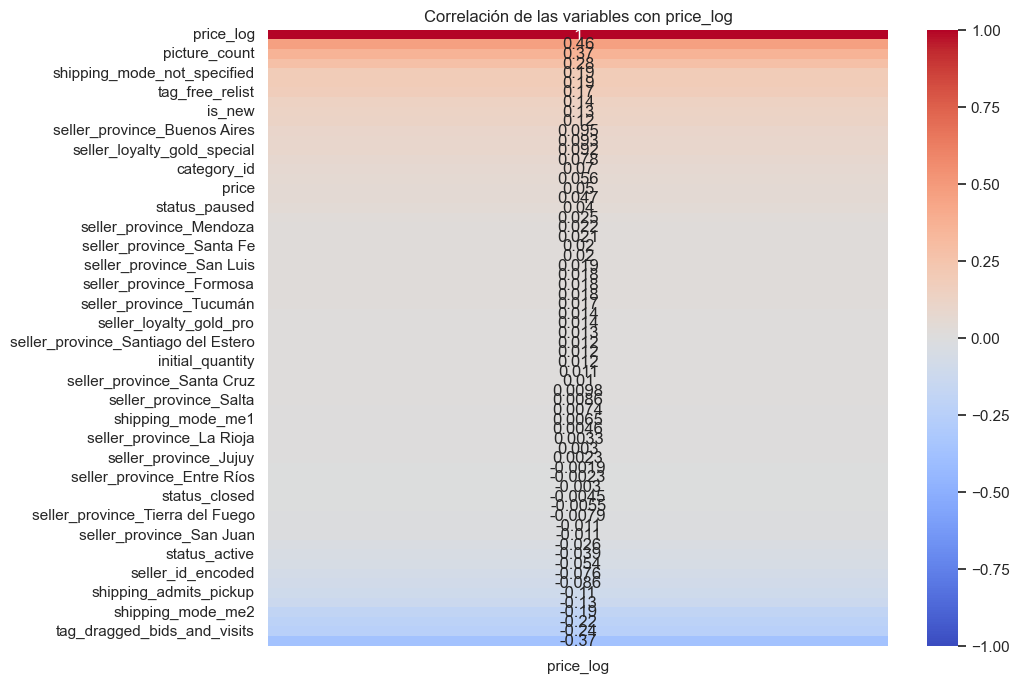

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Añadir columna logarítmica al dataframe
correlation_matrix = df.copy()
correlation_matrix['price_log'] = y_log

# Calcular la matriz de correlaciones numéricas
corr_matrix = correlation_matrix.corr(numeric_only=True)

# Heatmap centrado en price_log
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix[['price_log']].sort_values(by='price_log', ascending=False), 
    annot=True, cmap='coolwarm', vmin=-1, vmax=1
)
plt.title("Correlación de las variables con price_log")
plt.show()


In [37]:
# Seleccionar solo columnas con correlación mayor a 0.15 o menor a -0.15
relevant_features = corr[abs(corr) > 0.1].drop('price_log').index.tolist()
print(relevant_features)


['buying_mode_classified', 'picture_count', 'tag_dragged_visits', 'shipping_mode_not_specified', 'seller_loyalty_silver', 'tag_free_relist', 'seller_loyalty_gold_premium', 'is_new', 'shipping_is_free', 'shipping_admits_pickup', 'seller_province_Capital Federal', 'shipping_mode_me2', 'seller_loyalty_bronze', 'tag_dragged_bids_and_visits', 'buying_mode_buy_it_now']


In [38]:
X = df[relevant_features]
y = y_log  # target log-transformado

X_train, X_test, y_train, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test_log, name):
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_test = np.expm1(y_test_log)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\nEvaluación de {name}:")
    print("MAE: ", round(mae, 2))
    print("RMSE:", round(rmse, 2))
    print("R²:  ", round(r2, 4))

    return mae, rmse, r2

evaluate_model(rf, X_test, y_test_log, "Random Forest")
evaluate_model(xgb, X_test, y_test_log, "XGBoost")


Evaluación de Random Forest:
MAE:  61659.51
RMSE: 7857260.78
R²:   0.0001

Evaluación de XGBoost:
MAE:  62107.91
RMSE: 7857851.0
R²:   -0.0


(62107.914817074794, 7857850.999542806, -1.6650283341190786e-05)

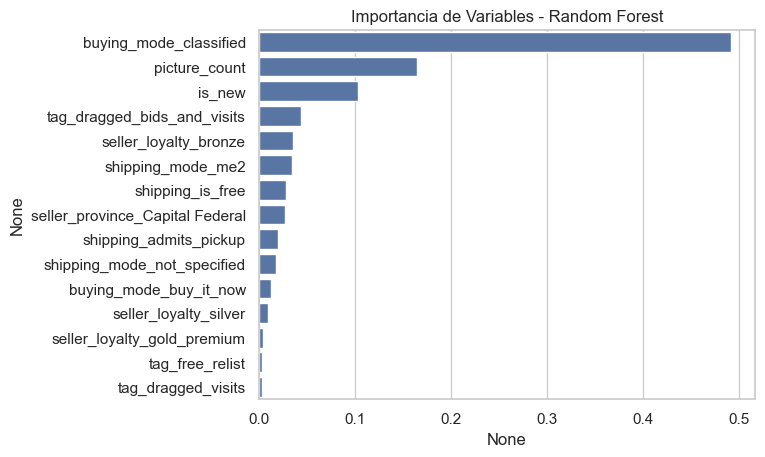

In [39]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=importances, y=importances.index)
plt.title('Importancia de Variables - Random Forest')
plt.show()


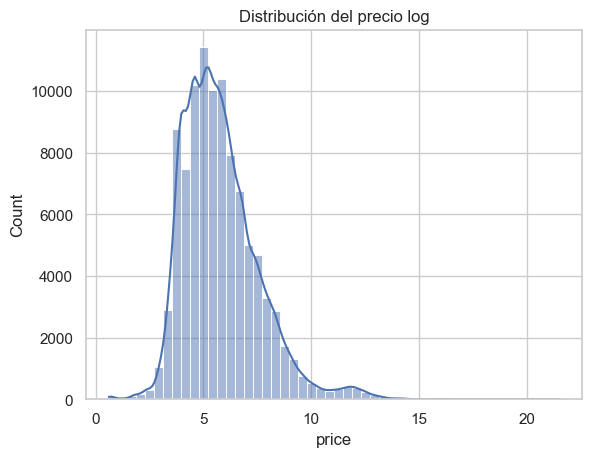

In [40]:
sns.histplot(y_log, bins=50, kde=True)
plt.title('Distribución del precio log')
plt.show()


In [41]:
y_pred_naive = np.repeat(np.mean(np.expm1(y_train)), len(y_test_log))
print("MAE baseline:", mean_absolute_error(np.expm1(y_test_log), y_pred_naive))


MAE baseline: 107906.56696501182


Aunque el modelo aprende ya que el modelo reduce el MAE de aplicar simplemente la media casi a la mitad tenemos una alta varianza de precios y outliers muy extremos que afectan el RMSE y R2.     
Se debe entonces probar con otro enfoque.

In [42]:
# Calcular IQR sobre y_log
Q1 = y_log.quantile(0.25)
Q3 = y_log.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Separar índices
non_outliers_idx = y_log.between(lower_bound, upper_bound)
outliers_idx = ~non_outliers_idx

print(f"Registros sin outliers: {non_outliers_idx.sum()}")
print(f"Registros con outliers: {outliers_idx.sum()}")


Registros sin outliers: 97304
Registros con outliers: 2685


In [43]:
X_no_outliers = X[non_outliers_idx]
y_no_outliers = y_log[non_outliers_idx]

X_outliers = X[outliers_idx]
y_outliers = y_log[outliers_idx]


In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# División
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

# Entrenamiento
model_main = RandomForestRegressor(random_state=42)
model_main.fit(X_train_main, y_train_main)


RandomForestRegressor(random_state=42)

In [45]:
# Entrenar solo si hay suficientes datos
if len(X_outliers) > 50:
    model_outliers = RandomForestRegressor(random_state=42)
    model_outliers.fit(X_outliers, y_outliers)
else:
    model_outliers = None


In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X_test, y_test_log, name):
    y_pred_log = model.predict(X_test)
    y_test = np.expm1(y_test_log)
    y_pred = np.expm1(y_pred_log)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\nEvaluación de {name}:")
    print("MAE: ", round(mae, 2))
    print("RMSE:", round(rmse, 2))
    print("R²:  ", round(r2, 4))

    return mae, rmse, r2


In [47]:
evaluate_model(model_main, X_test_main, y_test_main, "Modelo principal (sin outliers)")

if model_outliers:
    evaluate_model(model_outliers, X_outliers, y_outliers, "Modelo para outliers")



Evaluación de Modelo principal (sin outliers):
MAE:  803.24
RMSE: 2183.32
R²:   0.0118

Evaluación de Modelo para outliers:
MAE:  1849798.83
RMSE: 52397620.76
R²:   0.0073


## Cambio de enfoque, variable objetivo si el producto vende o no.

In [48]:
df['was_sold'] = (df['sold_quantity'] > 0).astype(int)


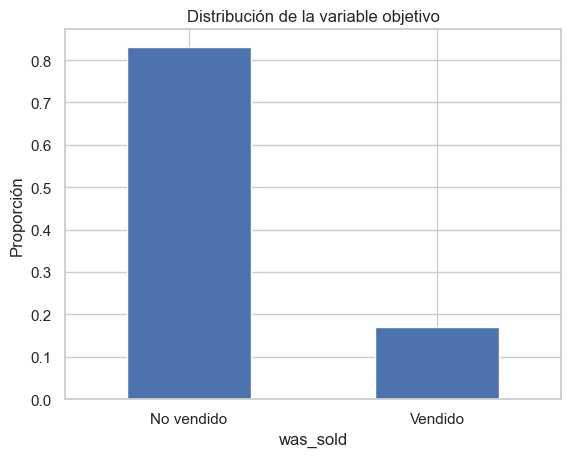

In [49]:
df['was_sold'].value_counts(normalize=True).plot(kind='bar')
plt.title("Distribución de la variable objetivo")
plt.xticks(ticks=[0, 1], labels=["No vendido", "Vendido"], rotation=0)
plt.ylabel("Proporción")
plt.show()


In [50]:
X = df.drop(columns=['id','sold_quantity', 'was_sold']) 
y = df['was_sold']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [51]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)
xgb_clf = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), use_label_encoder=False, eval_metric='logloss', random_state=42)

rf_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)


c:\Users\linam\Documents\GitHub\mercado-libre-data-scientist-prueba\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:34:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [52]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model_classification(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(f"\n{name} Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

evaluate_model_classification(rf_clf, X_test, y_test, "Random Forest")
evaluate_model_classification(xgb_clf, X_test, y_test, "XGBoost")



Random Forest Report:
              precision    recall  f1-score   support

           0     0.8905    0.9756    0.9311     16614
           1     0.7741    0.4111    0.5370      3384

    accuracy                         0.8800     19998
   macro avg     0.8323    0.6933    0.7340     19998
weighted avg     0.8708    0.8800    0.8644     19998

Confusion Matrix:
[[16208   406]
 [ 1993  1391]]

XGBoost Report:
              precision    recall  f1-score   support

           0     0.9576    0.8250    0.8863     16614
           1     0.4885    0.8206    0.6124      3384

    accuracy                         0.8242     19998
   macro avg     0.7230    0.8228    0.7494     19998
weighted avg     0.8782    0.8242    0.8400     19998

Confusion Matrix:
[[13706  2908]
 [  607  2777]]


In [53]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 1. Dividir datos antes de aplicar SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Aplicar SMOTE SOLO al entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verificación de balance
from collections import Counter
print("Distribución original:", Counter(y_train))
print("Después de SMOTE:", Counter(y_train_resampled))


Distribución original: Counter({0: 66457, 1: 13534})
Después de SMOTE: Counter({1: 66457, 0: 66457})


In [54]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)


In [56]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = model_xgb.predict(X_test)

c:\Users\linam\Documents\GitHub\mercado-libre-data-scientist-prueba\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:37:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [57]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Random Forest
print("Random Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# XGBoost
print("\nXGBoost Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Random Forest Metrics:
Accuracy: 0.8768876887688769
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     16614
           1       0.68      0.51      0.58      3384

    accuracy                           0.88     19998
   macro avg       0.79      0.73      0.76     19998
weighted avg       0.87      0.88      0.87     19998

Confusion Matrix:
 [[15810   804]
 [ 1658  1726]]

XGBoost Metrics:
Accuracy: 0.8952395239523953
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94     16614
           1       0.76      0.56      0.64      3384

    accuracy                           0.90     19998
   macro avg       0.84      0.76      0.79     19998
weighted avg       0.89      0.90      0.89     19998

Confusion Matrix:
 [[16006   608]
 [ 1487  1897]]


In [59]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter

# 1. Calcular peso para la clase minoritaria en el conjunto de entrenamiento original (sin SMOTE)
scale_pos_weight = Counter(y_train)[0] / Counter(y_train)[1]
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# 2. Crear y entrenar el modelo XGBoost con ese peso
model_xgb_weighted = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

model_xgb_weighted.fit(X_train, y_train)  # Entrenamos con datos originales, no SMOTE

# 3. Predecir en el conjunto de prueba
y_pred_weighted = model_xgb_weighted.predict(X_test)

# 4. Evaluar
accuracy = accuracy_score(y_test, y_pred_weighted)
report = classification_report(y_test, y_pred_weighted)
cm = confusion_matrix(y_test, y_pred_weighted)

print(f"Accuracy con scale_pos_weight: {accuracy:.4f}\n")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)


scale_pos_weight: 4.91


c:\Users\linam\Documents\GitHub\mercado-libre-data-scientist-prueba\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:43:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy con scale_pos_weight: 0.8242

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.82      0.89     16614
           1       0.49      0.82      0.61      3384

    accuracy                           0.82     19998
   macro avg       0.72      0.82      0.75     19998
weighted avg       0.88      0.82      0.84     19998

Confusion Matrix:
 [[13706  2908]
 [  607  2777]]


In [60]:
import numpy as np
from sklearn.metrics import f1_score

# Obtener probabilidades para la clase positiva
y_proba = model_xgb_weighted.predict_proba(X_test)[:,1]

best_f1 = 0
best_threshold = 0.5

for thresh in np.arange(0.1, 0.9, 0.05):
    y_pred_thresh = (y_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"Mejor threshold: {best_threshold:.2f} con F1-score: {best_f1:.4f}")


Mejor threshold: 0.65 con F1-score: 0.6568


In [62]:
y_pred_best = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


              precision    recall  f1-score   support

           0       0.93      0.92      0.93     16614
           1       0.64      0.68      0.66      3384

    accuracy                           0.88     19998
   macro avg       0.79      0.80      0.79     19998
weighted avg       0.88      0.88      0.88     19998

Confusion Matrix:
 [[15317  1297]
 [ 1095  2289]]


Interpretación   
El modelo es muy bueno para detectar los productos que NO se venden (clase 0): tiene alta precisión (93%) y recall (92%), con pocos falsos positivos y falsos negativos en esta clase.

Para la clase 1 (productos vendidos), la performance es moderada:

Precision 64%: De todos los productos que el modelo predijo como vendidos, el 64% realmente se vendieron. Hay un 36% de falsos positivos.

Recall 68%: El modelo detecta el 68% de los productos vendidos, pero pierde el 32% (falsos negativos).

La F1-score para la clase 1 es 0.66, un valor intermedio que indica que el equilibrio entre precisión y recall puede mejorarse.

Dado que la clase 1 es la minoritaria, este resultado no es raro. Pero puede ser importante mejorar la detección de los productos vendidos para no perder oportunidades.

vamos a realizar una validación cruzada estratificada para evaluar el modelo XGBoost optimizando el threshold de clasificación optimizando F1

In [65]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np
from xgboost import XGBClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for train_idx, val_idx in cv.split(X, y):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    scale_pos_weight = (y == 0).sum() / (y == 1).sum()
    model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
    model.fit(X_train_cv, y_train_cv)

    y_proba_cv = model.predict_proba(X_val_cv)[:, 1]

    best_f1 = 0
    for t in thresholds:
        y_pred_cv = (y_proba_cv >= t).astype(int)
        f1 = f1_score(y_val_cv, y_pred_cv)
        if f1 > best_f1:
            best_f1 = f1
    f1_scores.append(best_f1)

print(f"F1 promedio cross-val con threshold tuning: {np.mean(f1_scores):.4f}")


F1 promedio cross-val con threshold tuning: 0.6493


In [66]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

# Guardar métricas para cada fold
metrics = []

for train_idx, val_idx in cv.split(X, y):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
    model.fit(X_train_cv, y_train_cv)

    y_proba_cv = model.predict_proba(X_val_cv)[:, 1]

    best_f1 = 0
    best_metrics = {}

    for t in thresholds:
        y_pred_cv = (y_proba_cv >= t).astype(int)
        f1 = f1_score(y_val_cv, y_pred_cv)
        if f1 > best_f1:
            best_f1 = f1
            best_metrics = {
                "threshold": t,
                "f1": f1,
                "precision": precision_score(y_val_cv, y_pred_cv),
                "recall": recall_score(y_val_cv, y_pred_cv),
                "confusion_matrix": confusion_matrix(y_val_cv, y_pred_cv),
                "report": classification_report(y_val_cv, y_pred_cv, output_dict=True)
            }

    metrics.append(best_metrics)

# Mostrar métricas promedio
avg_f1 = np.mean([m['f1'] for m in metrics])
avg_precision = np.mean([m['precision'] for m in metrics])
avg_recall = np.mean([m['recall'] for m in metrics])

print(f"F1 promedio: {avg_f1:.4f}")
print(f"Precision promedio: {avg_precision:.4f}")
print(f"Recall promedio: {avg_recall:.4f}")


F1 promedio: 0.6493
Precision promedio: 0.6824
Recall promedio: 0.6193
